In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from matplotlib.dates import datestr2num
import torch.optim as optim
from sklearn import preprocessing
import math

In [3]:
FILENAME = 'daytabase.csv'

BATCH_SIZE = 16
TRAIN_SPLIT = 0.8

NUM_FEATURES = 150*23
NUM_UNITS = 1024
NUM_USERS = 9
NUM_EPOCHS = 1

EPSILON = 0.1
DELTA = 10**-5
NORM_CLIP=4*150

SIGMA = 0.3

RHO = 0.5

UTILITY_WEIGHTS = (1,1,1,1)
PRIVACY_WEIGHTS =(2,1)

MAP_PARAMS = 2

NUM_GRIDS = 4

## Load Data

In [4]:
class ChaniaDataset(Dataset):
    def __init__(self, csv_file, transform=None, normalize=True):
        self.augmented_data = pd.read_csv(csv_file, usecols = list(range(1,NUM_FEATURES+1)))
        self.userlabels = pd.read_csv(csv_file, usecols=[0])
        self.transform = transform
        
        if normalize:
            self.augmented_data=(self.augmented_data-self.augmented_data.mean())/self.augmented_data.std()

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        data = self.augmented_data.iloc[idx].values
        data = data.astype('float').reshape(-1,NUM_FEATURES)            
        user = self.userlabels.iloc[idx].values
        user = user.astype('int').reshape(-1,1)
        sample = {'x':data, 'u':user}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [6]:
class ToTensor(object):
    def __call__(self, sample):
        data, user = sample['x'], sample['u']
        return {'x':torch.from_numpy(data), 'u':torch.from_numpy(user)}

In [7]:
chania_dataset = ChaniaDataset(csv_file=FILENAME, transform=ToTensor(), normalize=False)

In [8]:
train_size=int(TRAIN_SPLIT*len(chania_dataset))
test_size = len(chania_dataset)-train_size

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(chania_dataset, [train_size, test_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Visualize Functions

In [11]:
def show_batch_wlabels(sample_batch,longlines=None,latlines=None):
    with torch.no_grad():
        data, users = sample_batch['x'], sample_batch['u']
        batch_size = len(data)
        lat = data[:,:,[12+23*i for i in range(150)]].numpy()
        long = data[:,:,[13+23*i for i in range(150)]].numpy()
        colors = np.repeat(users.numpy(),150, axis=2)
        for i in range(batch_size):
            plt.scatter(long, lat, c=colors)
        if longlines is not None:
            for line in longlines.numpy():
                plt.axvline(line)
        if latlines is not None:
            for line in latlines.numpy():
                plt.axhline(line)

In [202]:
# def show_privatizer(x, y, u, uhat):
#     with torch.no_grad():
#         fig, ax = plt.subplots(1,3,sharex=False,sharey=False,figsize=(15,5))
#         ax[0].set_title("Input Data")
#         ax[1].set_title("Obfuscated Data")
#         ax[2].set_title("Adversary Estimate")
        
#         print(x[:,:,[13+23*i for i in range(150)]].numpy().shape)
        
#         color = np.repeat(u.numpy(),150).reshape(-1,1).tolist()
#         ax[0].scatter(x[:,:,[13+23*i for i in range(150)]].numpy(),
#                       x[:,:,[12+23*i for i in range(150)]].numpy())
# #                       c=color) #TODO check this
#         ax[1].scatter(y[:,:,[13+23*i for i in range(150)]].numpy(),
#                       y[:,:,[12+23*i for i in range(150)]].numpy())
#         _, upred = torch.max(uhat.data,1)
        
#         ax[2].scatter(y[:,:,[13+23*i for i in range(150)]].numpy(),
#                       y[:,:,[12+23*i for i in range(150)]].numpy(),
#                       c=np.repeat(upred.numpy(),150)) #TODO check this
        
        
def show_privatizer(x, y, u, uhat):
    with torch.no_grad():
        fig, ax = plt.subplots(1,3,figsize=(15,5))
        #sharex=True,sharey=True,
        ax[0].set_title("Input Data")
        ax[1].set_title("Obfuscated Data")
        ax[2].set_title("Adversary Estimate")
        _, upred = torch.max(uhat.data,1)
        for i in range(150):
            ax[0].scatter(x[:,:,13+23*i].numpy(),x[:,:,12+23*i].numpy(),c=u.unsqueeze(0).numpy().T.tolist())
            ax[1].scatter(y[:,:,13+23*i].numpy(),y[:,:,12+23*i].numpy(),c='black')
            ax[2].scatter(y[:,:,13+23*i].numpy(),y[:,:,12+23*i].numpy(),c=upred.numpy().reshape(-1,1).tolist())

In [13]:
def show_maps(x, y,npoints=100):
    with torch.no_grad():
        fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
        ax[0].set_title("Map from Input Data")
        ax[1].set_title("Map from Obfuscated Data")
        
        grid = torch.empty(npoints,1,2).uniform_(5)-2.5
        tr = [grid[:,:,1]**i*grid[:,:,0]**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)]
        poly_grid = torch.cat(tr,1)
        poly_grid = poly_grid.view(-1,6)
        
        bx = signal_map_params(x,MAP_PARAMS).float()
        by = signal_map_params(y,MAP_PARAMS).float()  
        x_predicted_rss = torch.mm(poly_grid,bx)
        y_predicted_rss = torch.mm(poly_grid,by)
        
        ax[0].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=x_predicted_rss.numpy())
        ax[1].scatter(grid[:,:,1].numpy(),grid[:,:,0].numpy(),c=y_predicted_rss.numpy())

## Define loss and helper functions

In [52]:
def privatizer_loss(x,y,u,uhat):
    bx = signal_map_params(x,MAP_PARAMS)
    by = signal_map_params(y,MAP_PARAMS)
    l1 = (bx-by).pow(2).mean()
    l2 = (x-y).pow(2).mean()
    l3 = (y[:,:,[12+23*i for i in range(150)] + [13+23*i for i in range(150)]]-
          x[:,:,[12+23*i for i in range(150)] + [13+23*i for i in range(150)]]).pow(2).mean() # check this power
    cx = density_count(x,NUM_GRIDS)
    cy = density_count(y,NUM_GRIDS)
    l4 = (cx-cy).pow(2).mean()/BATCH_SIZE
    l = torch.nn.CrossEntropyLoss()
    l5 = l(uhat,u)
    w1,w2,w3,w4 = UTILITY_WEIGHTS
    return RHO*(w1*l1+w2*l2+w3*l3+w4*l4)-(1-RHO)*l5

In [15]:
def poly(degree, long, lat):
    return torch.cat([long**i*lat**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)],1)

def signal_map_params(x,degree):    
    polynomial = poly(degree, x[:,:,[13+23*i for i in range(150)]].reshape(-1,1), 
                      x[:,:,[12+23*i for i in range(150)]].reshape(-1,1))
    beta = torch.mm(torch.inverse(torch.mm(torch.transpose(polynomial,0,1), polynomial)),
                  torch.mm(torch.transpose(polynomial,0,1), x[:,:,[6+23*i for i in range(150)]].reshape(-1,1)))
    return beta

In [42]:
def density_count(x, num_grids):
    count = torch.zeros(num_grids,num_grids)
    for i in range(150):
        count += partial_density_count(x[:,:,i*23:(i+1)*23], num_grids)
    return count
    

def partial_density_count(x, num_grids):
    count = torch.zeros(num_grids,num_grids)
    x1min=torch.min(x[:,:,13])
    x2min=torch.min(x[:,:,12])
    size1 = torch.max(x[:,:,13])-x1min
    size2 = torch.max(x[:,:,12])-x2min
    a_all = []
    c_all = []
    for i in range(num_grids):
        for j in range(num_grids):
            a = x1min+(size1/num_grids*i)
            a_all.append(a)
            b = x1min+(size1/num_grids*(i+1))
            a_all.append(b)
            c = x2min+(size2/num_grids*j)
            c_all.append(c)
            d = x2min+(size2/num_grids*(j+1))
            c_all.append(d)
            if i == num_grids-1 and j != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
            elif j == num_grids-1 and i != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            elif j == num_grids-1 and i == num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            else:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
    return count

In [50]:
def adversary_loss(u,uhat):
    l = torch.nn.CrossEntropyLoss()
    return l(uhat,u)

## Define adversary

In [19]:
adversary = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_USERS)
)
adversary.double()

Sequential(
  (0): Linear(in_features=3450, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=1024, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=9, bias=True)
)

In [20]:
adversary_optimizer = optim.Adam(adversary.parameters(),lr=0.001, betas=(0.9,0.999))

## Define privatizers

#### GAP

In [21]:
gap_privatizer = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_FEATURES)
)
gap_privatizer.double()
gap_privatizer_optimizer = optim.Adam(gap_privatizer.parameters(),lr=0.001, betas=(0.9,0.999))

#### Local DP

In [22]:
def dp_privatizer(x):
    normvec = torch.norm(x,p=2,dim=2)
    scalevec = NORM_CLIP/normvec
    scalevec[scalevec>1] = 1
    x = torch.transpose(torch.transpose(x,0,1)*scalevec,0,1).double()
    sigma = (NORM_CLIP/EPSILON)*math.sqrt(2*math.log(1.25/DELTA))
    noise = torch.normal(mean=torch.zeros_like(x),std=sigma).double()
    y = x + noise
    return y

#### Gaussian Noise

In [23]:
def noise_privatizer(x):
    noise = torch.normal(mean=torch.zeros_like(x),std=SIGMA).double()
    y = x + noise
    return y

# TRAIN

In [24]:
PRIVATIZER = noise_privatizer

In [53]:
# for each epoch
for epoch in range(NUM_EPOCHS):
    
    # iterate through the training dataset
    for i, batch in enumerate(train_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        if PRIVATIZER == gap_privatizer:
            # reset privatizer gradients
            gap_privatizer_optimizer.zero_grad()
        
        # privatize x
        y = PRIVATIZER(x)
        
        # reset adversary gradients
        adversary_optimizer.zero_grad()
        
        # estimate userIDs and original locations
        uhat = adversary(y).squeeze()
        
        # train adversary
        aloss = adversary_loss(u,uhat)
        aloss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(adversary.parameters(), 1000)
        adversary_optimizer.step()
        
        # evaluate utility loss
        ploss = privatizer_loss(x,y,u,uhat)
        
        if PRIVATIZER == gap_privatizer:
            # train privatizer
            ploss.backward()
            # check that gradients are non-zero
            # for param in gap_privatizer.parameters():
                # print(param.grad)
            torch.nn.utils.clip_grad_norm_(gap_privatizer.parameters(), 1000)
            gap_privatizer_optimizer.step()
        
        # print progress
        if i % 100 == 99:
            print(i+1,"aloss:",aloss.item(),"ploss:",ploss.item())
          
        # stop early
        if i == 1000:
            pass
print("done")

# with torch.no_grad():
#     with open(RESULT_FILENAME, "a") as fd:
#         fd.write(str(aloss.item()))
#         fd.write(", ")
#         fd.write(str(ploss.item()))
#         fd.write(", ")

done


# Test

In [60]:
# do not keep track of gradients
with torch.no_grad():
    correct = 0
    total = 0
    dist_error = 0
    l1,l2,l3,l4,l5 = 0,0,0,0,0
    
    # iterate through test data
    for i,batch in enumerate(test_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        # privatize x
        y = PRIVATIZER(x)
        
        # estimate userID and location
        estimate = adversary(x).squeeze()
        uhat, lochat = estimate[:,:9], estimate[:,9:]
        
        # Privacy Metric
        _, upred = torch.max(uhat.data,1)
        total+=u.size(0)
        correct+=(upred==u).sum().item()
#         dist_error += (x[:,:,12:14]-lochat).pow(2).mean().item()
        
        # Utility Metrics       
        bx = signal_map_params(x,MAP_PARAMS)
        by = signal_map_params(y,MAP_PARAMS)
        l1 = (bx-by).pow(2).mean()
        l2 = (x-y).pow(2).mean()
        l3 = (y[:,:,[12+23*i for i in range(150)] + [13+23*i for i in range(150)]]-
              x[:,:,[12+23*i for i in range(150)] + [13+23*i for i in range(150)]]).pow(2).mean() # check this power
        cx = density_count(x,NUM_GRIDS)
        cy = density_count(y,NUM_GRIDS)
        l4 = (cx-cy).pow(2).mean()/BATCH_SIZE
        l = torch.nn.CrossEntropyLoss()
        l5 = l(uhat,u)
        
        # stop early
        if i==3:
            break
        
    print("Adversary Accuracy:", 100*correct/total)
#     print("Average estimated location error:",dist_error/(i+1))
    print("")
    
    print("Adversary Loss:", l5.item()/(i+1))
    print("Sigmal Map:", l1.item()/(i+1))
    print("Distortion:", l2.item()/(i+1))
    print("Geographic Distortion:", l3.item()/(i+1))
    print("Density Count:",l4.item()/(i+1))

Adversary Accuracy: 10.9375

Adversary Loss: 0.5506636661292413
Sigmal Map: 148105273904032.03
Distortion: 0.02231110470109518
Geographic Distortion: 0.023354308302756702
Density Count: 651.919921875


# Visualize

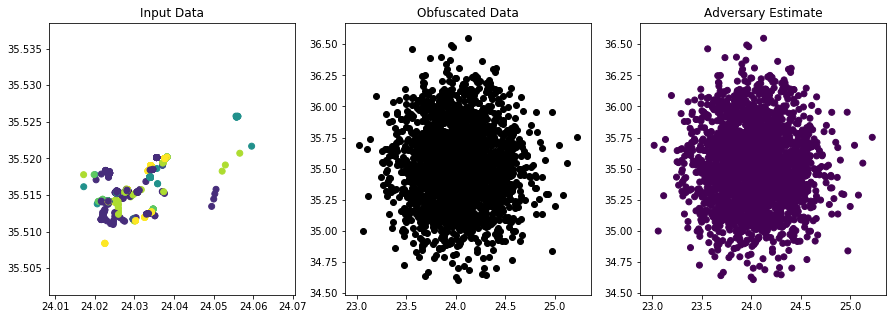

In [203]:
show_privatizer(x,y,u,uhat)

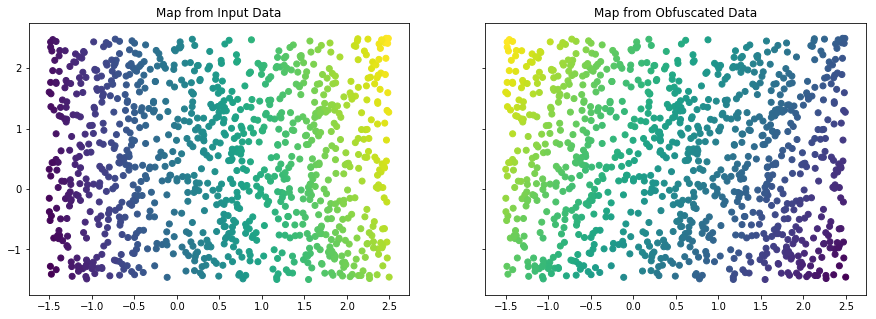

In [58]:
show_maps(x,y,1000)